# GOAL: Filter out weird CNVs

(7/30/25) When I didn't filter by length first, even post-clustering it kept some spikes. So I'm gonna go with length filtering. Note that length filtering will set weird spiky stuff to 1|1 instead of to neighboring region, it will then be set back to the appropriate CN by clustering (presumably...)

In [1]:
show_plots=FALSE

## 0. Load everything in

In [2]:
source("utils_high-depth.R")
library(GenomicRanges)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [3]:
# ----------------------------
# SET FIXED PARAMETERS
# ----------------------------
prefix <- "/n/data1/hms/dbmi/park/ann_caplin/SMaHT/PTA"
batch_names <- c("batch-6-uniform_lung", "batch-7-uniform_colon")
binsize <- "500000"
lambda_str <- "1024-512"
lambda <- 512
hiscanner_cell_type_ix=3

In [4]:
special_case=""

In [5]:
NBIN_MIN=20

In [6]:
#seg_merged_df <- as.data.frame(get_cell_data(prefix, batch_names, binsize, lambda_str, lambda, file_suffix="_seg_merged"))

In [7]:
seg_merged_df <- read_rds("seg_merged_df_CN-LOH-fix.rds")

In [8]:
orig_seg_merged_df_colnames <- colnames(seg_merged_df)

In [9]:
seg_merged_df$CN <- as.character(seg_merged_df$CN)

# Split CN into two numeric components
cn_split <- str_split(seg_merged_df$CN, "\\|")

# Extract alleles as numeric values
seg_merged_df$CN_A <- as.numeric(sapply(cn_split, `[`, 1))
seg_merged_df$CN_B <- as.numeric(sapply(cn_split, `[`, 2))

# Compute total copy number
seg_merged_df$CN_total <- seg_merged_df$CN_A + seg_merged_df$CN_B

seg_merged_df$length <- seg_merged_df$end - seg_merged_df$start
seg_merged_df$amt_dna <- seg_merged_df$length*seg_merged_df$CN_total
seg_merged_df$is_CNV <- (seg_merged_df$CN_A != 1 | seg_merged_df$CN_B != 1)
seg_merged_df$is_LOH <- (seg_merged_df$CN_A == 0 | seg_merged_df$CN_B == 0)

In [10]:
# Function to merge adjacent segments with same CN
merge_adjacent_segments <- function(df) {
  df_merged <- df %>%
    # Sort by cell_name, chrom, and start position
    arrange(cell_name, chrom, start) %>%
    # Group by cell_name and chrom
    group_by(cell_name, chrom) %>%
    # Create groups for consecutive segments with same CN
    mutate(
      # Check if CN changes from previous row
      cn_change = CN != lag(CN, default = CN[1]),
      # Create group ID for consecutive same CN segments
      cn_group = cumsum(cn_change)
    ) %>%
    # Group by cell_name, chrom, and cn_group to merge segments
    group_by(cell_name, chrom, cn_group) %>%
    summarise(
      # Keep first values for these columns
      bin_name = bin_name[1],
      CN = CN[1],
      sample = sample[1],
      batch_name = batch_name[1],
      cell_type = cell_type[1],
      VAF_ESTIMATE = VAF_ESTIMATE[1],
      
      # Update start and end
      start = min(start),
      end = max(end),
      
      # Sum NBIN
      NBIN = sum(NBIN),
      
      # Sum RDR_SUM and recalculate RDR_MEAN
      RDR_SUM = sum(RDR_SUM),
      RDR_MEAN = sum(RDR_SUM) / sum(NBIN),
      
      # Calculate weighted mean for VAF_MEAN
      VAF_MEAN = sum(VAF_MEAN * NBIN) / sum(NBIN),
      
      .groups = 'drop'
    ) %>%
    # Remove the helper column
    select(-cn_group) %>%
    # Reorder columns to match original
    select(bin_name, start, end, CN, chrom, NBIN, RDR_SUM, RDR_MEAN, 
           VAF_MEAN, VAF_ESTIMATE, sample, cell_name, batch_name, cell_type)

  return(df_merged)
}

In [11]:
head(seg_merged_df)

,start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,cell_name,batch_name,cell_type,CN_A,CN_B,CN_total,length,amt_dna,is_CNV,is_LOH
,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<lgl>
1,10033,40215785,1|1,1,75,92.45457,1.232728,0.4139456,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1,1,2,40205752,80411504,FALSE,FALSE
2,40215786,42773801,2|1,1,5,8.18406,1.636812,0.4320153,0.38,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,2,1,3,2558015,7674045,TRUE,FALSE
3,42773802,248946312,1|1,1,340,485.13323,1.426862,0.4089636,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1,1,2,206172510,412345020,FALSE,FALSE
4,10289,133787311,1|1,10,244,345.54392,1.416164,0.4215530,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1,1,2,133777022,267554044,FALSE,FALSE
5,103470,9962845,1|1,11,18,30.59577,1.699765,0.4385454,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1,1,2,9859375,19718750,FALSE,FALSE
6,9962846,16678434,2|1,11,13,27.08888,2.083760,0.4503974,0.44,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,2,1,3,6715588,20146764,TRUE,FALSE


In [12]:
seg_merged_df <- seg_merged_df %>% mutate(bin_name=paste0(cell_name, ":", chrom, ":", start, "-", end))

In [13]:
#cell_df <- get_cell_data(prefix, batch_names, binsize, lambda_str, lambda, file_suffix="")

In [14]:
cell_df <- read_rds("cell_df_CN-LOH-fix.rds")

In [15]:
orig_cell_df_colnames <- colnames(cell_df)

In [16]:
cell_df$CN_signal <- cell_df$RDR * cell_df$gamma

### Filter by autosomes (ST002 is XY so there is no BAF signal from sex chromosomes!)

In [17]:
cell_df <- cell_df %>% filter(CHROM %in% c(1:22))
seg_merged_df <- seg_merged_df %>% filter(chrom %in% c(1:22))

## 1. Filtering by CNV length

### 1a. Look at CNV length distribution

In [18]:
head(seg_merged_df)

,start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,⋯,batch_name,cell_type,CN_A,CN_B,CN_total,length,amt_dna,is_CNV,is_LOH,bin_name
,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<lgl>,<chr>
1,10033,40215785,1|1,1,75,92.45457,1.232728,0.4139456,NA,ST002,⋯,batch-6-uniform_lung,lung,1,1,2,40205752,80411504,FALSE,FALSE,SMACS1CLQTQR:1:10033-40215785
2,40215786,42773801,2|1,1,5,8.18406,1.636812,0.4320153,0.38,ST002,⋯,batch-6-uniform_lung,lung,2,1,3,2558015,7674045,TRUE,FALSE,SMACS1CLQTQR:1:40215786-42773801
3,42773802,248946312,1|1,1,340,485.13323,1.426862,0.4089636,NA,ST002,⋯,batch-6-uniform_lung,lung,1,1,2,206172510,412345020,FALSE,FALSE,SMACS1CLQTQR:1:42773802-248946312
4,10289,133787311,1|1,10,244,345.54392,1.416164,0.4215530,NA,ST002,⋯,batch-6-uniform_lung,lung,1,1,2,133777022,267554044,FALSE,FALSE,SMACS1CLQTQR:10:10289-133787311
5,103470,9962845,1|1,11,18,30.59577,1.699765,0.4385454,NA,ST002,⋯,batch-6-uniform_lung,lung,1,1,2,9859375,19718750,FALSE,FALSE,SMACS1CLQTQR:11:103470-9962845
6,9962846,16678434,2|1,11,13,27.08888,2.083760,0.4503974,0.44,ST002,⋯,batch-6-uniform_lung,lung,2,1,3,6715588,20146764,TRUE,FALSE,SMACS1CLQTQR:11:9962846-16678434


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


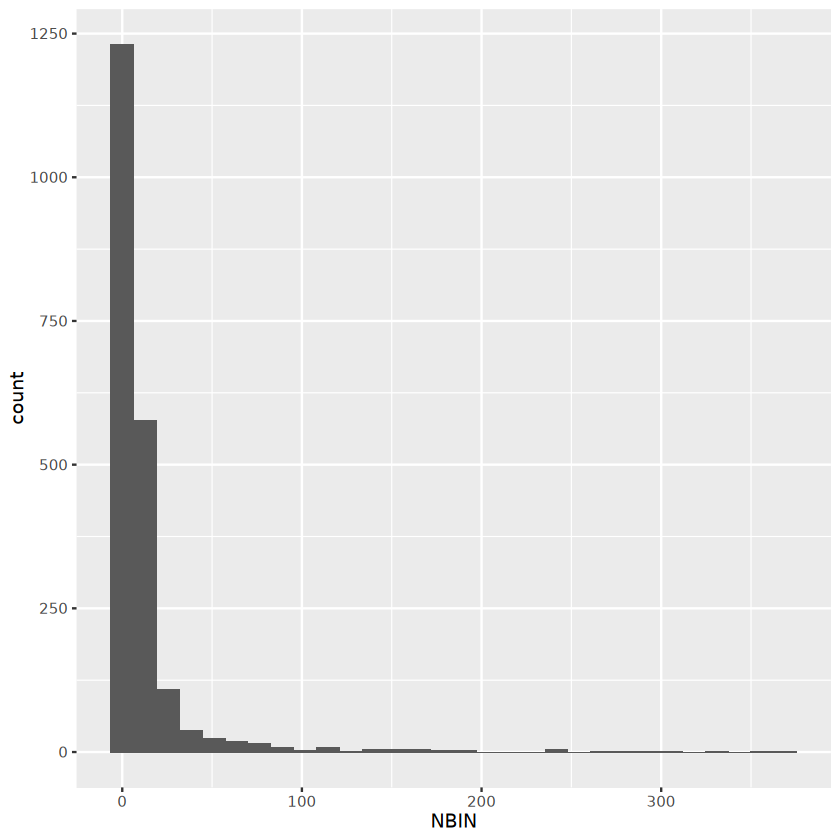

In [19]:
ggplot(seg_merged_df[seg_merged_df$is_CNV,], aes(x=NBIN)) + geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


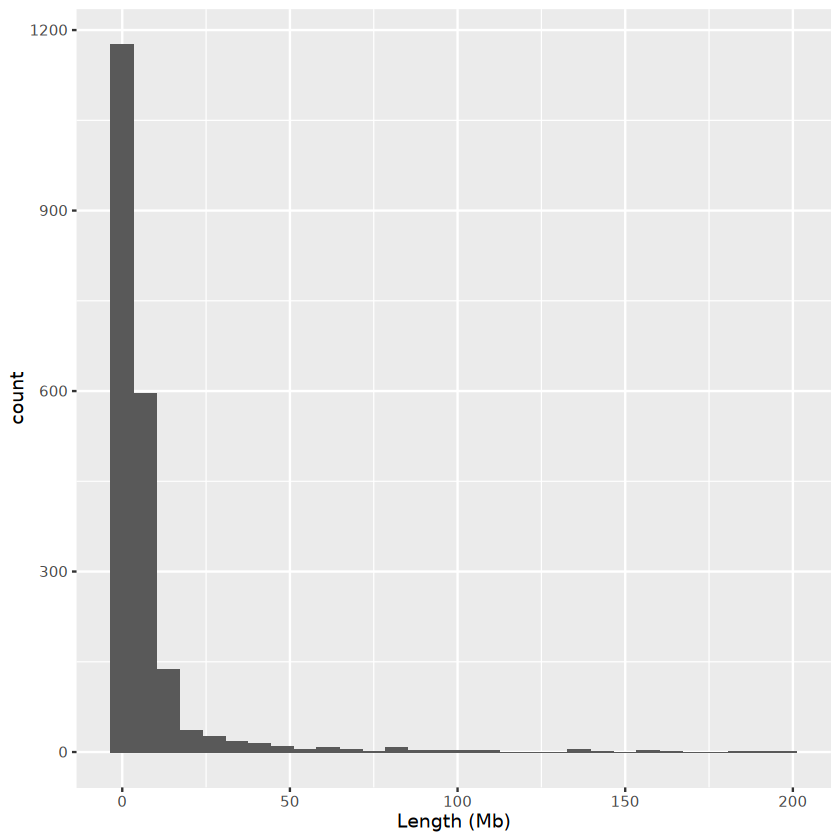

In [20]:
ggplot(seg_merged_df[seg_merged_df$is_CNV,], aes(x=length/10^6)) + geom_histogram() + xlab("Length (Mb)")

integer(0)

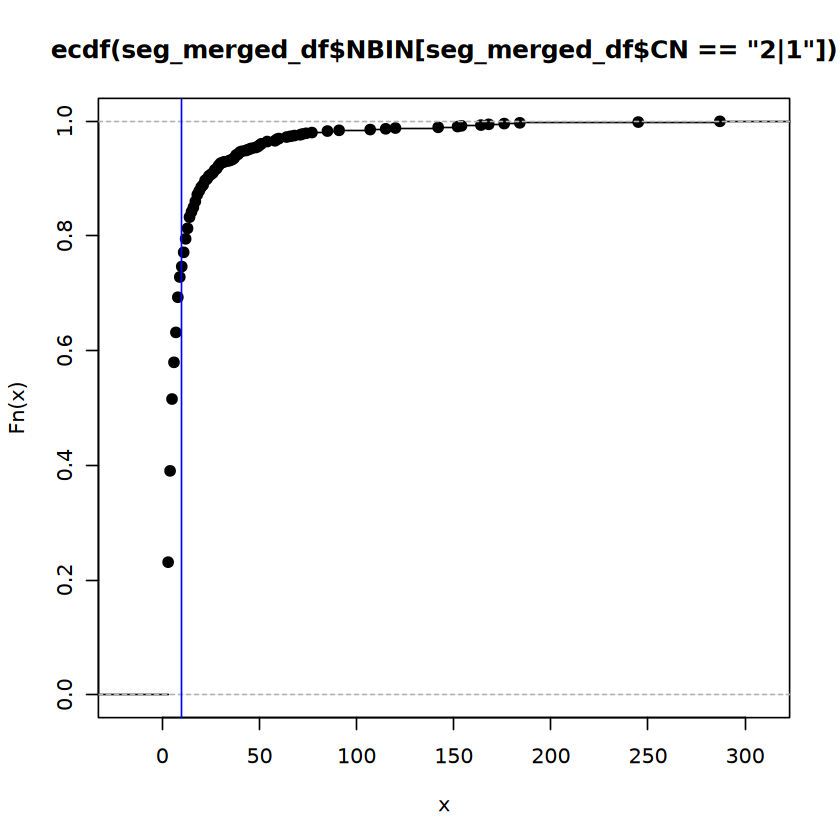

In [21]:
plot(ecdf(seg_merged_df$NBIN[seg_merged_df$CN=="2|1"])) + abline(v=10, col="blue")

integer(0)

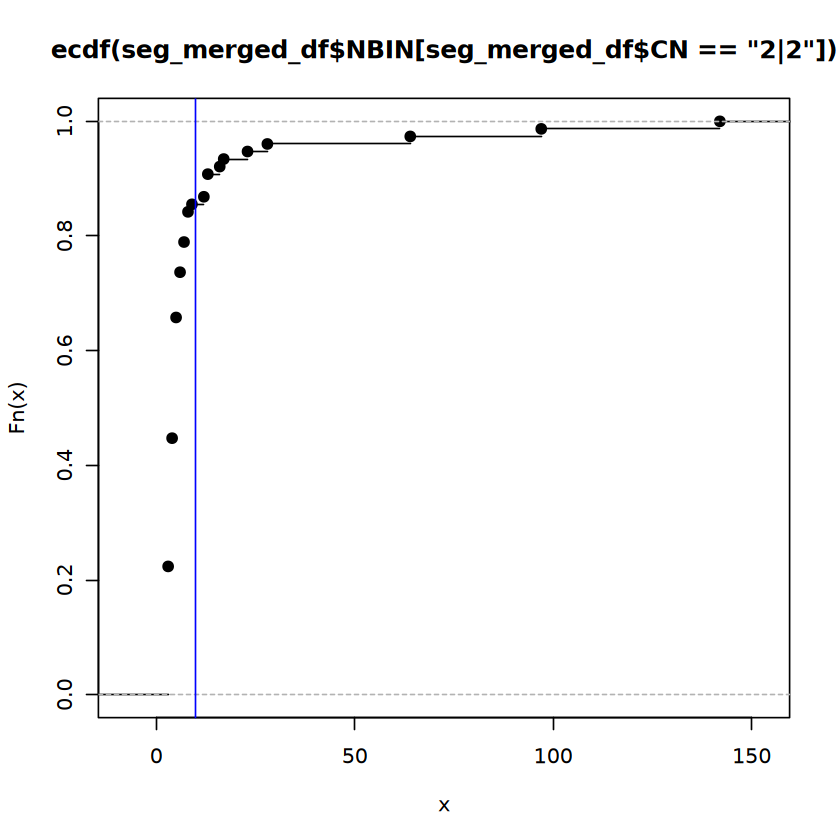

In [22]:
plot(ecdf(seg_merged_df$NBIN[seg_merged_df$CN=="2|2"])) + abline(v=10, col="blue")

In [23]:
if (show_plots){
    for (cell_name_curr in unique(seg_merged_df$cell_name[seg_merged_df$CN=="2|2"])){
            sample <- seg_merged_df$sample[seg_merged_df$cell_name==cell_name_curr][1]
            batch <- seg_merged_df$batch_name[seg_merged_df$cell_name==cell_name_curr][1]
            display_cell_image(prefix, batch, binsize, lambda_str, lambda, sample, cell_name_curr)
        }

    }

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


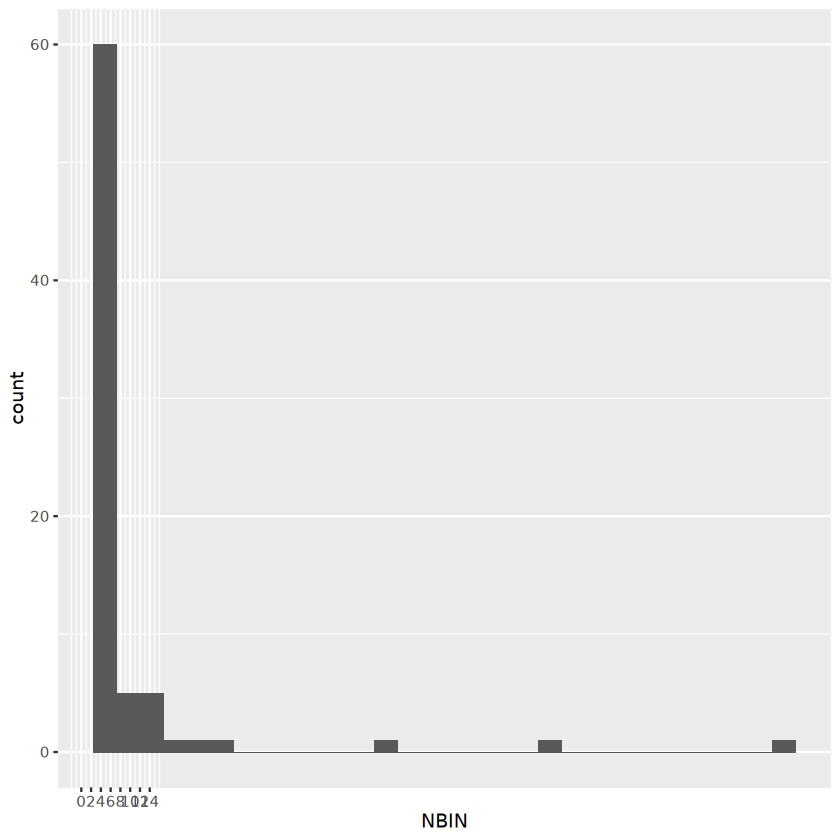

In [24]:
ggplot(seg_merged_df[seg_merged_df$CN=="2|2",], aes(x=NBIN)) + geom_histogram() + scale_x_continuous(breaks = seq(0, 14, by = 2))

In [25]:
head(cell_df)

,CHROM,START,END,A,B,N,TOTAL,pBAF,BAF,MAJOR,⋯,prob,CN_A,CN_B,CN_total,gamma,sample,cell_name,batch_name,cell_type,CN_signal
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,1,10033,1365962,407,303,52,710,0.4267606,0.4267606,407,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1.376692
2,1,1365963,1975218,1118,1084,139,2202,0.4922797,0.4922797,1118,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1.303807
3,1,1975219,2485674,1174,1553,229,2727,0.5694903,0.4305097,1553,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1.377272
4,1,2485675,3115514,1197,755,145,1952,0.3867828,0.3867828,1197,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1.836524
5,1,3115515,3623265,5210,2425,259,7635,0.3176162,0.3176162,5210,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,1.931956
6,1,3623266,4135875,7073,9952,577,17025,0.5845521,0.4154479,9952,⋯,1,1,1,2,1.448953,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung,2.396293


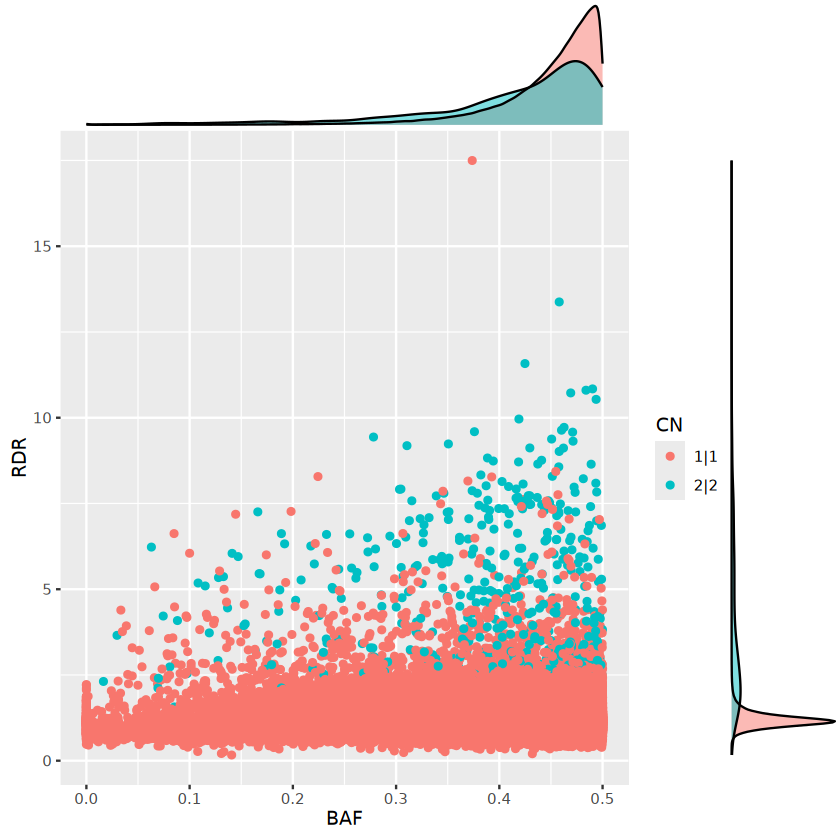

In [26]:
library(ggExtra)
p <- ggplot(cell_df[cell_df$CN=="2|2" | cell_df$CN=="1|1",], aes(x=BAF, y=RDR, color=CN)) + geom_point()
ggMarginal(p, type = "density", groupFill = TRUE)

integer(0)

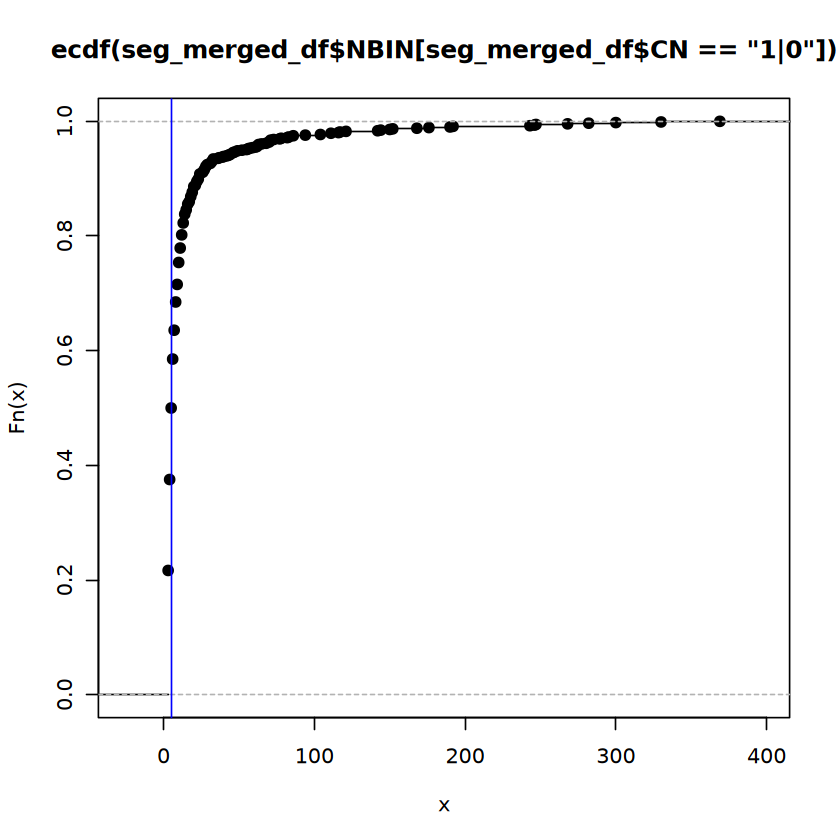

In [27]:
plot(ecdf(seg_merged_df$NBIN[seg_merged_df$CN=="1|0"])) + abline(v=5, col="blue")

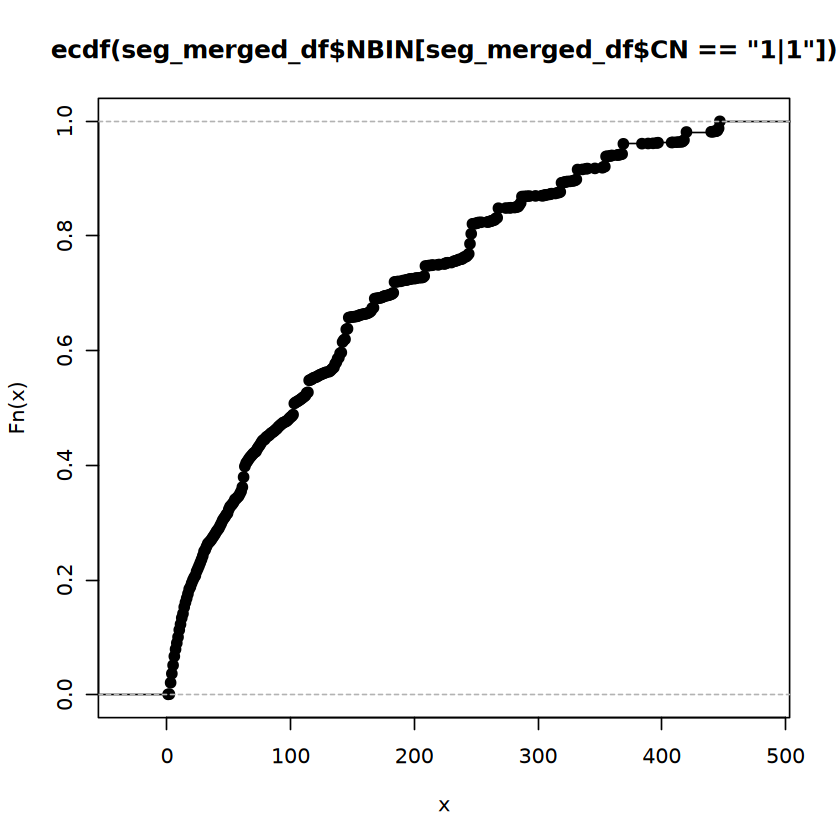

In [28]:
plot(ecdf(seg_merged_df$NBIN[seg_merged_df$CN=="1|1"]))

### 1b. Add seg info to cell df

In [29]:
cell_df$seg_num <- NA
cell_df$seg_NBIN <- NA

for (cell_name_curr in unique(cell_df$cell_name)){
    message(cell_name_curr)
    cell_df_cell <- cell_df %>%
      filter(cell_name == cell_name_curr) %>%
      mutate(CHROM = as.character(CHROM))
    
    seg_df_cell <- seg_merged_df %>%
      filter(cell_name == cell_name_curr) %>%
      mutate(chrom = as.character(chrom))
    
    cell_gr <- GRanges(
      seqnames = cell_df_cell$CHROM,
      ranges = IRanges(start = cell_df_cell$START, end = cell_df_cell$END)
    )
    
    seg_gr <- GRanges(
      seqnames = seg_df_cell$chrom,
      ranges = IRanges(start = seg_df_cell$start, end = seg_df_cell$end)
    )
    
    mcols(seg_gr)$seg_num <- seq_len(nrow(seg_df_cell))
    mcols(seg_gr)$NBIN <- seg_df_cell$NBIN
    
    
    hits <- findOverlaps(cell_gr, seg_gr)
    
    overlap_df <- data.frame(
      bin_idx = queryHits(hits),
      seg_num = mcols(seg_gr)$seg_num[subjectHits(hits)],
      NBIN = mcols(seg_gr)$NBIN[subjectHits(hits)]
    )
    
    # Initialize columns
    cell_df_cell$seg_num <- NA
    cell_df_cell$seg_NBIN <- NA
    
    # Assign values where overlaps exist
    cell_df_cell$seg_num[overlap_df$bin_idx] <- overlap_df$seg_num
    cell_df_cell$seg_NBIN[overlap_df$bin_idx] <- overlap_df$NBIN

    cell_df[cell_df$cell_name == cell_name_curr, ] <- cell_df_cell

}

SMACS1CLQTQR

SMACS237GKP7

SMACS2CZN69C

SMACS3LUUS3E

SMACS3WFHOU9

SMACS65XVA6Y

SMACS6PTJONJ

SMACS6X5TALT

SMACS7CK4YZS

SMACS7OGXC17

SMACS847FR52

SMACS89AFNQ1

SMACS8QNX6W9

SMACS9H3Q4IB

SMACS9H3UGVZ

SMACS9V7SO8E

SMACSAOGX8BS

SMACSBJ3VO7L

SMACSBM69H6Q

SMACSBYB858H

SMACSDEENE5R

SMACSDLFV1VU

SMACSFUIX8H4

SMACSG1A48WW

SMACSG1OVSEO

SMACSG2YG7OW

SMACSGMFMORL

SMACSGP4CMDT

SMACSH1WE7O7

SMACSIY9YVEC

SMACSLDLRC9G

SMACSM8QGSBA

SMACSN3QDA78

SMACSOWHSDLN

SMACSPE8QXLN

SMACSPIS7WK8

SMACSPNEFIGY

SMACSPQBK92L

SMACSQ3F6FX4

SMACSQCAZA5F

SMACSQW3ECKL

SMACSRGEXSYT

SMACSS68ZEYW

SMACSSBO1MHW

SMACSSH8IU1K

SMACSSM6NUU7

SMACST592TOV

SMACSTLU27CI

SMACSTU79Z9B

SMACSVVXLPOS

SMACSW7REYP9

SMACSWN1GU3J

SMACSYBMLS5K

SMACSYHXWV41

SMACSZ2136VF

SMACSZJOM8X7

SMACS1GFACQW

SMACS1OZ5RFS

SMACS2T3VKE6

SMACS3VLR8BN

SMACS5CAR9VS

SMACS61SL8NG

SMACS67U1B8D

SMACS6BVVVQN

SMACS6N94UKL

SMACS6WBMRYB

SMACS8VB15ZM

SMACS8WX9HRR

SMACS916XMLA

SMACS9CX64QF

SMACS9DI9AEO

SMACSA

In [30]:
cell_df$seg_is_LOH <- (cell_df$CN_A == 0 | cell_df$CN_B == 0)
cell_df$seg_is_CNV <- (cell_df$CN != "1|1")

### 1c. Filter out small CNVs

In [31]:
#filter_out_CNV <- ((cell_df$CN_total > 0 & cell_df$seg_is_LOH & cell_df$seg_NBIN < 5) | 
#                  (cell_df$seg_is_CNV & cell_df$seg_NBIN < 10))

# 0|0 can't do the NBIN filter because actually looks like the signal itself is lack of bins
# need to investigate this further

#cell_df$filter_out_CNV <- (cell_df$CN_total > 0 & cell_df$seg_NBIN < 20)

cell_df$filter_out_CNV <- cell_df$seg_NBIN < NBIN_MIN

In [32]:
names(cell_df)

[1] "CHROM"          "START"          "END"            "A"             
 [5] "B"              "N"              "TOTAL"          "pBAF"          
 [9] "BAF"            "MAJOR"          "MINOR"          "RDR"           
[13] "OBS"            "EXP"            "VAF_MEAN"       "RDR_MEAN"      
[17] "VAF_ESTIMATE"   "CN"             "pval"           "prob"          
[21] "CN_A"           "CN_B"           "CN_total"       "gamma"         
[25] "sample"         "cell_name"      "batch_name"     "cell_type"     
[29] "CN_signal"      "seg_num"        "seg_NBIN"       "seg_is_LOH"    
[33] "seg_is_CNV"     "filter_out_CNV"

In [33]:
library(dplyr)
library(purrr)

# Step 1: Build segment-level metadata
seg_df <- cell_df %>%
  group_by(cell_name, CHROM, seg_num) %>%
  summarize(CN = CN[1], filter_out_CNV = filter_out_CNV[1], .groups = "drop")

# Step 2: For each segment, find replacement CN if it's filtered
seg_df <- seg_df %>%
  group_by(cell_name, CHROM) %>%
  group_modify(~ {
    segs <- .x
    seg_num_to_CN <- segs %>%
      filter(!filter_out_CNV) %>%
      select(seg_num, CN) %>%
      deframe()

    # Replace CN for filtered segments
    new_CN <- map2_chr(segs$seg_num, segs$filter_out_CNV, function(seg_i, to_filter) {
      if (!to_filter) return(segs$CN[segs$seg_num == seg_i][1])

      max_offset <- nrow(segs)
      for (offset in 1:max_offset) {
        prev <- seg_i - offset
        next_ix <- seg_i + offset
        if (as.character(prev) %in% names(seg_num_to_CN)) return(seg_num_to_CN[as.character(prev)])
        if (as.character(next_ix) %in% names(seg_num_to_CN)) return(seg_num_to_CN[as.character(next)])
      }

      # fallback
      return(NA_character_)
    })

    segs$CN_smoothed <- new_CN
    return(segs)
  }) %>%
  ungroup()

# Step 3: Join back to original bin-level cell_df using seg_num
cell_df_updated <- cell_df %>%
  left_join(seg_df %>% select(cell_name, CHROM, seg_num, CN_smoothed), 
            by = c("cell_name", "CHROM", "seg_num")) %>%
  mutate(CN := CN_smoothed) %>%
  select(-CN_smoothed)


In [34]:
library(dplyr)
library(purrr)

# Step 1: Segment-level metadata
seg_df <- cell_df %>%
  group_by(cell_name, CHROM, seg_num) %>%
  summarize(CN = CN[1], filter_out_CNV = filter_out_CNV[1], .groups = "drop")

# Step 2: Smooth CNs at segment-level
seg_df <- seg_df %>%
  group_by(cell_name, CHROM) %>%
  group_modify(~ {
    segs <- .x

    # Lookup table of non-filtered segments
    seg_num_to_CN <- segs %>%
      filter(!filter_out_CNV) %>%
      select(seg_num, CN) %>%
      deframe()

    # New CNs, replacing filtered ones with nearest non-filtered neighbor
    new_CN <- map2_chr(segs$seg_num, segs$filter_out_CNV, function(seg_i, to_filter) {
      if (!to_filter) {
        # Just return current CN
        return(segs$CN[segs$seg_num == seg_i][1])
      }

      max_offset <- nrow(segs)
      for (offset in 1:max_offset) {
        prev_seg <- seg_i - offset
        next_seg <- seg_i + offset

        if (as.character(prev_seg) %in% names(seg_num_to_CN)) {
          return(seg_num_to_CN[as.character(prev_seg)])
        }
        if (as.character(next_seg) %in% names(seg_num_to_CN)) {
          return(seg_num_to_CN[as.character(next_seg)])
        }
      }

      # Fallback: no neighbor found
      return("1|1")
    })

    segs$CN_smoothed <- new_CN
    segs
  }) %>%
  ungroup()

# Step 3: Join back to bin-level dataframe
cell_df_filtered <- cell_df %>%
  left_join(seg_df %>% select(cell_name, CHROM, seg_num, CN_smoothed),
            by = c("cell_name", "CHROM", "seg_num")) %>%
  mutate(CN = CN_smoothed) %>%
  select(-CN_smoothed)


In [35]:
na_segs <- seg_df %>%
  filter(filter_out_CNV, is.na(CN_smoothed))

In [36]:
na_segs

cell_name,CHROM,seg_num,CN,filter_out_CNV,CN_smoothed
<chr>,<chr>,<int>,<chr>,<lgl>,<chr>


In [37]:
unique(cell_df_filtered$CN)

[1] "1|1" "2|1" "1|0" "2|0" "3|0" "3|1" "4|0" "2|2" "4|1" "0|0" "3|2"

In [38]:
segment_calls <- cell_df_filtered %>%
  group_by(cell_name, seg_num) %>%
  summarise(
    chrom=CHROM[1],
    start=min(START),
    end=max(END),
    seg_NBIN = seg_NBIN[1],
    seg_CN = CN[1],
    .groups = "drop"
  )


In [39]:
sum(segment_calls$seg_CN=="2|2")

[1] 7

In [40]:
segment_calls$final_CN <- segment_calls$seg_CN
cell_df_filtered$final_CN <- cell_df_filtered$CN

In [41]:
names(segment_calls)

[1] "cell_name" "seg_num"   "chrom"     "start"     "end"       "seg_NBIN" 
[7] "seg_CN"    "final_CN"

In [42]:
orig_seg_merged_df_colnames

[1] "start"        "end"          "CN"           "chrom"        "NBIN"        
 [6] "RDR_SUM"      "RDR_MEAN"     "VAF_MEAN"     "VAF_ESTIMATE" "sample"      
[11] "cell_name"    "batch_name"   "cell_type"

In [43]:
#seg_merged_df_orig <- as.data.frame(get_cell_data(prefix, batch_names, binsize, lambda_str, lambda, file_suffix="_seg_merged"))

In [44]:
seg_merged_df_orig <- read_rds("seg_merged_df_CN-LOH-fix.rds")

In [45]:
seg_merged_df_orig <- seg_merged_df_orig %>% filter(chrom %in% c(1:22))

In [46]:
seg_merged_df_orig <- seg_merged_df_orig %>% mutate(bin_name=paste0(cell_name, ":", chrom, ":", start, "-", end))
segment_calls <- segment_calls %>% mutate(bin_name=paste0(cell_name, ":", chrom, ":", start, "-", end))
#(seg_merged_df$cell_name, "_", seg_merged_df$chrom, ":", seg_merged_df$start, "-", seg_merged_df$end)
#segment_calls$bin_name <- paste0(seg_merged_df$chrom, ":", seg_merged_df$start, "-", seg_merged_df$end)

In [47]:
setdiff(unique(seg_merged_df_orig$bin_name), unique(segment_calls$bin_name))

[1] "SMACSS68ZEYW:11:6324638-15649766"   "SMACSS68ZEYW:15:69200552-71758407" 
 [3] "SMACSS68ZEYW:17:3389289-14633447"   "SMACSS68ZEYW:17:29411923-68371837" 
 [5] "SMACSS68ZEYW:17:72956299-77511968"  "SMACSS68ZEYW:2:192412593-202261457"
 [7] "SMACSS68ZEYW:2:218198739-242183395" "SMACSS68ZEYW:20:34054826-37619295" 
 [9] "SMACSS68ZEYW:22:24822802-26409403"  "SMACSS68ZEYW:22:47383221-49918481" 
[11] "SMACSS68ZEYW:3:79316815-84972324"   "SMACSS68ZEYW:4:30741850-35332101"  
[13] "SMACSS68ZEYW:4:71914665-75594362"   "SMACSS68ZEYW:4:94334864-96919860"  
[15] "SMACSS68ZEYW:8:30931386-77349994"   "SMACSS68ZEYW:9:121487750-123539448"
[17] "SMACSW7REYP9:5:16615677-20313326"   "SMACSW7REYP9:5:39158459-64901573"

In [48]:
seg_merged_df_orig[(!seg_merged_df_orig$bin_name %in% unique(segment_calls$bin_name)),]

,start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,cell_name,batch_name,cell_type,bin_name
,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
4413,6324638,15649766,0|0,11,12,0.25268536,0.0210571136,0.0406897961,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:11:6324638-15649766
4441,69200552,71758407,0|0,15,0,0.00000000,NA,NA,NA,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:15:69200552-71758407
4458,3389289,14633447,0|0,17,11,0.04585995,0.0041690859,0.0002228164,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:17:3389289-14633447
4462,29411923,68371837,0|0,17,11,0.85713844,0.0779216761,0.0550798429,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:17:29411923-68371837
4464,72956299,77511968,0|0,17,0,0.00000000,NA,NA,NA,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:17:72956299-77511968
4503,192412593,202261457,0|0,2,15,0.89989463,0.0599929754,0.0415747757,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:2:192412593-202261457
4507,218198739,242183395,0|0,2,3,0.50320009,0.1677333620,0.0027772247,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:2:218198739-242183395
4511,34054826,37619295,0|0,20,3,0.64211352,0.2140378399,0.0023590895,0,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:20:34054826-37619295
4515,24822802,26409403,0|0,22,0,0.00000000,NA,NA,NA,ST002,SMACSS68ZEYW,batch-6-uniform_lung,lung,SMACSS68ZEYW:22:24822802-26409403


In [49]:
seg_merged_df_orig[(!seg_merged_df_orig$bin_name %in% unique(segment_calls$bin_name)) & (seg_merged_df_orig$NBIN > 0 & seg_merged_df_orig$CN != "0|0"),]

start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,cell_name,batch_name,cell_type,bin_name
<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>


In [50]:
seg_merged_df_orig <- merge(seg_merged_df_orig, segment_calls %>% select(bin_name, final_CN), by="bin_name", all.x=TRUE)

In [51]:
sum(is.na(seg_merged_df_orig$final_CN))

[1] 18

In [52]:
seg_merged_df_orig$CN[!is.na(seg_merged_df_orig$final_CN)] <- seg_merged_df_orig$final_CN[!is.na(seg_merged_df_orig$final_CN)]

In [53]:
seg_merged_df_orig$final_CN <- NULL

In [54]:
head(seg_merged_df_orig)

,bin_name,start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,cell_name,batch_name,cell_type
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,SMACS1CLQTQR:1:10033-40215785,10033,40215785,1|1,1,75,92.45457,1.232728,0.4139456,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
2,SMACS1CLQTQR:1:40215786-42773801,40215786,42773801,1|1,1,5,8.18406,1.636812,0.4320153,0.38,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
3,SMACS1CLQTQR:1:42773802-248946312,42773802,248946312,1|1,1,340,485.13323,1.426862,0.4089636,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
4,SMACS1CLQTQR:10:10289-133787311,10289,133787311,1|1,10,244,345.54392,1.416164,0.4215530,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
5,SMACS1CLQTQR:11:103470-9962845,103470,9962845,1|1,11,18,30.59577,1.699765,0.4385454,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
6,SMACS1CLQTQR:11:16678435-135076523,16678435,135076523,1|1,11,215,339.99322,1.581364,0.4332127,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung


In [55]:
cell_df_filtered %>% filter(cell_name=="SMHT002LungS2", CHROM==17)

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


CHROM,START,END,A,B,N,TOTAL,pBAF,BAF,MAJOR,⋯,cell_name,batch_name,cell_type,CN_signal,seg_num,seg_NBIN,seg_is_LOH,seg_is_CNV,filter_out_CNV,final_CN
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<lgl>,<lgl>,<lgl>,<chr>


In [56]:
seg_merged_df_final <- merge_adjacent_segments(seg_merged_df_orig)

In [57]:
nrow(seg_merged_df_final)

[1] 2493

In [58]:
nrow(seg_merged_df_orig)

[1] 5603

In [59]:
cell_df_filtered$cell_name_seg_num=paste0(cell_df_filtered$cell_name, ":", cell_df_filtered$seg_num)
segment_calls$cell_name_seg_num=paste0(segment_calls$cell_name, ":", segment_calls$seg_num)

In [60]:
sum(is.na(cell_df_filtered$final_CN))

[1] 0

In [61]:
sum(is.na(cell_df_filtered$CN) | cell_df_filtered$CN != cell_df_filtered$final_CN)

[1] 0

In [62]:
sum(is.na(cell_df_filtered$CN) | cell_df_filtered$CN == cell_df_filtered$final_CN)

[1] 506703

In [63]:
cell_df_filtered$CN <- cell_df_filtered$final_CN

In [64]:
orig_cell_df_colnames

[1] "CHROM"        "START"        "END"          "A"            "B"           
 [6] "N"            "TOTAL"        "pBAF"         "BAF"          "MAJOR"       
[11] "MINOR"        "RDR"          "OBS"          "EXP"          "VAF_MEAN"    
[16] "RDR_MEAN"     "VAF_ESTIMATE" "CN"           "pval"         "prob"        
[21] "CN_A"         "CN_B"         "CN_total"     "gamma"        "sample"      
[26] "cell_name"    "batch_name"   "cell_type"

In [65]:
cell_df_filtered$CN <- as.character(cell_df_filtered$CN)

# Split CN into two numeric components
cn_split <- str_split(cell_df_filtered$CN, "\\|")

# Extract alleles as numeric values
cell_df_filtered$CN_A <- as.numeric(sapply(cn_split, `[`, 1))
cell_df_filtered$CN_B <- as.numeric(sapply(cn_split, `[`, 2))

# Compute total copy number
cell_df_filtered$CN_total <- cell_df_filtered$CN_A + cell_df_filtered$CN_B

In [66]:
cell_data_output <- cell_df_filtered[,orig_cell_df_colnames]

## 3. Add back the RDR for sex chromosomes

In [67]:
seg_merged_df_rdr <- as.data.frame(get_cell_data(prefix, batch_names, binsize, lambda_str, lambda, file_suffix="_seg_merged", hiscanner_dir_name="hiscanner_multisample-false_rdr-only"))

/n/data1/hms/dbmi/park/ann_caplin/SMaHT/PTA/batch-6-uniform_lung/hiscanner_multisample-false_rdr-only/binsize_500000_lambda_1024-512

Found 56 input_table.txt files

batch-6-uniform_lung

Reading cell_name.txt files...

Loaded data for 5890 rows

/n/data1/hms/dbmi/park/ann_caplin/SMaHT/PTA/batch-7-uniform_colon/hiscanner_multisample-false_rdr-only/binsize_500000_lambda_1024-512

Found 46 input_table.txt files

batch-7-uniform_colon

Reading cell_name.txt files...

Loaded data for 2379 rows



In [68]:
cell_data_rdr <- get_cell_data(prefix, batch_names, binsize, lambda_str, lambda, file_suffix="", hiscanner_dir_name="hiscanner_multisample-false_rdr-only")

/n/data1/hms/dbmi/park/ann_caplin/SMaHT/PTA/batch-6-uniform_lung/hiscanner_multisample-false_rdr-only/binsize_500000_lambda_1024-512

Found 56 input_table.txt files

batch-6-uniform_lung

Reading cell_name.txt files...

Loaded data for 293129 rows

/n/data1/hms/dbmi/park/ann_caplin/SMaHT/PTA/batch-7-uniform_colon/hiscanner_multisample-false_rdr-only/binsize_500000_lambda_1024-512

Found 46 input_table.txt files

batch-7-uniform_colon

Reading cell_name.txt files...

Loaded data for 243230 rows



In [69]:
seg_merged_df_rdr <- seg_merged_df_rdr %>% filter(chrom %in% c("X", "Y"))

In [70]:
cell_data_rdr <- cell_data_rdr %>% filter(CHROM %in% c("X", "Y"))

In [71]:
orig_seg_merged_df_colnames

[1] "start"        "end"          "CN"           "chrom"        "NBIN"        
 [6] "RDR_SUM"      "RDR_MEAN"     "VAF_MEAN"     "VAF_ESTIMATE" "sample"      
[11] "cell_name"    "batch_name"   "cell_type"

In [72]:
head(seg_merged_df_orig)

,bin_name,start,end,CN,chrom,NBIN,RDR_SUM,RDR_MEAN,VAF_MEAN,VAF_ESTIMATE,sample,cell_name,batch_name,cell_type
,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,SMACS1CLQTQR:1:10033-40215785,10033,40215785,1|1,1,75,92.45457,1.232728,0.4139456,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
2,SMACS1CLQTQR:1:40215786-42773801,40215786,42773801,1|1,1,5,8.18406,1.636812,0.4320153,0.38,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
3,SMACS1CLQTQR:1:42773802-248946312,42773802,248946312,1|1,1,340,485.13323,1.426862,0.4089636,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
4,SMACS1CLQTQR:10:10289-133787311,10289,133787311,1|1,10,244,345.54392,1.416164,0.4215530,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
5,SMACS1CLQTQR:11:103470-9962845,103470,9962845,1|1,11,18,30.59577,1.699765,0.4385454,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung
6,SMACS1CLQTQR:11:16678435-135076523,16678435,135076523,1|1,11,215,339.99322,1.581364,0.4332127,NA,ST002,SMACS1CLQTQR,batch-6-uniform_lung,lung


In [73]:
cell_data_rdr$A <- NA
cell_data_rdr$B <- NA
cell_data_rdr$N <- NA
cell_data_rdr$TOTAL <- NA
cell_data_rdr$pBAF <- NA
cell_data_rdr$BAF <- NA
cell_data_rdr$MAJOR <- NA
cell_data_rdr$MINOR <- NA
cell_data_rdr$VAF_MEAN <- NA
cell_data_rdr$VAF_ESTIMATE <- NA
cell_data_rdr$CN_A <- NA
cell_data_rdr$CN_B <- NA
cell_data_rdr$CN_total <- cell_data_rdr$CN
cell_data_rdr$pval <- NA
cell_data_rdr$prob <- NA

In [74]:
cell_data_output <- rbind(cell_data_output, cell_data_rdr)

In [75]:
seg_merged_df_output <- seg_merged_df_final[,orig_seg_merged_df_colnames]

In [76]:
seg_merged_df_rdr$VAF_MEAN <- NA
seg_merged_df_rdr$VAF_ESTIMATE <- NA
seg_merged_df_output <- rbind(seg_merged_df_output, seg_merged_df_rdr)

In [77]:
#cells_to_use <- Step1_filter_to_qc_pass_cells()
#cell_data_output <- cell_data_output %>% filter(cell_name %in% cells_to_use)
#seg_merged_df_output <- seg_merged_df_output %>%  filter(cell_name %in% cells_to_use)

In [78]:
write_rds(cell_data_output, paste0("cell_data_df_NBIN-filtered_", NBIN_MIN, special_case, ".rds"))

In [79]:
write_rds(seg_merged_df_output, paste0("seg_merged_df_NBIN-filtered_", NBIN_MIN, special_case, ".rds"))